## All you need is love… And a pet!

<img src="img/dataset-cover.jpg" width="920">

Here we are going to build a classifier to predict whether an animal from an animal shelter will be adopted or not (aac_intakes_outcomes.csv, available at: https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/version/1#aac_intakes_outcomes.csv). You will be working with the following features:

1. *animal_type:* Type of animal. May be one of 'cat', 'dog', 'bird', etc.
2. *intake_year:* Year of intake
3. *intake_condition:* The intake condition of the animal. Can be one of 'normal', 'injured', 'sick', etc.
4. *intake_number:* The intake number denoting the number of occurrences the animal has been brought into the shelter. Values higher than 1 indicate the animal has been taken into the shelter on more than one occasion.
5. *intake_type:* The type of intake, for example, 'stray', 'owner surrender', etc.
6. *sex_upon_intake:* The gender of the animal and if it has been spayed or neutered at the time of intake
7. *age_upon\_intake_(years):* The age of the animal upon intake represented in years
8. *time_in_shelter_days:* Numeric value denoting the number of days the animal remained at the shelter from intake to outcome.
9. *sex_upon_outcome:* The gender of the animal and if it has been spayed or neutered at time of outcome
10. *age_upon\_outcome_(years):* The age of the animal upon outcome represented in years
11. *outcome_type:* The outcome type. Can be one of ‘adopted’, ‘transferred’, etc.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from itertools import combinations 
import ast
from sklearn.linear_model import LogisticRegression
import seaborn as sn
%matplotlib inline

data_folder = './data/'

### A) Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). 
- Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. 
- Standardize the values of each feature in the data to have mean 0 and variance 1.

The use of external libraries is not permitted in part A, except for numpy and pandas. 
You can drop entries with missing values.

In [16]:
# Preprocess dataset
columns = ['animal_type', 'intake_year', 'intake_condition', 'intake_number', 'intake_type', 'sex_upon_intake', \
          'age_upon_intake_(years)', 'time_in_shelter_days', 'sex_upon_outcome', 'age_upon_outcome_(years)', \
          'outcome_type']

original_data = pd.read_csv(data_folder+'aac_intakes_outcomes.csv', usecols=columns)
data_df = original_data.copy()

# assign ouput label in col 'adopted'
data_df['outcome_type'] = data_df['outcome_type'].apply(lambda x: True if x=='Adoption' else False)
data_df.rename(columns={'outcome_type': 'adopted'}, inplace=True)
data_df.dropna(inplace=True) # drop 'na' cells
data_df


,adopted,sex_upon_outcome,age_upon_outcome_(years),animal_type,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days
0,False,Neutered Male,10.000000,Dog,Normal,Stray,Neutered Male,10.000000,2017,1.0,0.588194
1,False,Neutered Male,7.000000,Dog,Normal,Public Assist,Neutered Male,7.000000,2014,2.0,1.259722
2,False,Neutered Male,6.000000,Dog,Normal,Public Assist,Neutered Male,6.000000,2014,3.0,1.113889
3,False,Neutered Male,10.000000,Dog,Normal,Owner Surrender,Neutered Male,10.000000,2014,1.0,4.970139
4,False,Neutered Male,16.000000,Dog,Injured,Public Assist,Neutered Male,16.000000,2013,1.0,0.119444
...,...,...,...,...,...,...,...,...,...,...,...
79667,False,Unknown,0.038356,Cat,Normal,Stray,Unknown,0.038356,2018,1.0,0.077083
79668,False,Unknown,2.000000,Other,Normal,Wildlife,Unknown,2.000000,2018,1.0,0.053472
79669,False,Unknown,1.000000,Other,Normal,Wildlife,Unknown,1.000000,2018,1.0,0.047917
79670,False,Intact Male,0.821918,Dog,Normal,Stray,Intact Male,0.410959,2018,1.0,1.762500


In [43]:
# Split into train & test set randomly (w/o using any external lib like scikitlearn)

def split_test_train(data_df, ratio):
    # shuffle df by taking 100% sample
    shuffled_df = data_df.sample(frac=1)
    
    # reset index, and drop it (i-e don't convert index into a new col which is done by default)
    shuffled_df = shuffled_df.reset_index(drop=True)

    # find idx where to split from
    split_index = int( len(shuffled_df) * ratio )

    # split the df
    train_df = shuffled_df[:split_index]
    test_df = shuffled_df[split_index:]

    return train_df, test_df

# just checking
train_df, test_df = split_test_train(data_df, ratio=0.8)
train_df

,adopted,sex_upon_outcome,age_upon_outcome_(years),animal_type,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days
0,False,Intact Male,2.000000,Dog,Normal,Stray,Intact Male,2.000000,2015,1.0,0.286806
1,False,Neutered Male,0.575342,Cat,Normal,Stray,Intact Male,0.575342,2016,1.0,0.777083
2,True,Neutered Male,3.000000,Dog,Normal,Stray,Neutered Male,3.000000,2014,1.0,3.869444
3,True,Spayed Female,2.000000,Dog,Normal,Stray,Intact Female,2.000000,2014,3.0,3.987500
4,False,Neutered Male,2.000000,Dog,Normal,Stray,Intact Male,2.000000,2015,1.0,4.340278
...,...,...,...,...,...,...,...,...,...,...,...
63731,False,Unknown,1.000000,Other,Normal,Wildlife,Unknown,1.000000,2018,1.0,1.514583
63732,True,Spayed Female,1.000000,Cat,Normal,Stray,Intact Female,1.000000,2016,1.0,36.406944
63733,False,Neutered Male,10.000000,Dog,Normal,Public Assist,Neutered Male,10.000000,2015,1.0,10.213889
63734,False,Neutered Male,1.000000,Dog,Normal,Public Assist,Intact Male,1.000000,2015,1.0,41.225694


In [44]:
# Logistic regression is binary classifier that ONLY works for binary (True/False) features

# convert categorical cols to binary (True/False) which works by creating new cols (E.g, 'sex' (M/F) --> 'sex_male'=(True/False), 'sex_female'=(True/False) ) 
categorical_cols = ['sex_upon_outcome', 'animal_type', 'intake_condition', 'intake_type', 'sex_upon_intake']
train_df = pd.get_dummies(train_df, columns=categorical_cols)
test_df = pd.get_dummies(test_df, columns=categorical_cols)

# just for checking
test_df


,adopted,age_upon_outcome_(years),age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,...,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,intake_type_Wildlife,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown
63736,False,1.000000,1.000000,2014,1.0,15.081250,False,False,False,True,...,False,True,False,False,False,False,False,False,True,False
63737,True,1.000000,1.000000,2016,3.0,39.875694,False,False,True,False,...,False,True,False,False,False,False,False,True,False,False
63738,True,0.164384,0.082192,2015,1.0,7.212500,False,False,False,True,...,False,True,False,False,False,True,False,False,False,False
63739,False,12.000000,12.000000,2014,1.0,322.997917,False,False,False,True,...,False,False,False,True,False,False,False,False,True,False
63740,True,2.000000,2.000000,2017,2.0,5.181944,False,False,True,False,...,False,False,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79666,True,4.000000,4.000000,2015,1.0,5.013194,False,False,False,True,...,False,True,False,False,False,False,False,False,True,False
79667,False,0.410959,0.410959,2017,1.0,4.540972,False,True,False,False,...,False,False,False,True,False,False,True,False,False,False
79668,False,1.000000,1.000000,2017,1.0,1.040972,True,False,False,False,...,False,False,False,True,False,True,False,False,False,False
79669,False,2.000000,2.000000,2017,1.0,9.796528,False,True,False,False,...,False,False,True,False,False,False,True,False,False,False


In [ ]:
# Create features and labels for both train and test set
X_train = train_df.drop(columns=["adopted"]) # input features, doesn't contain lable. label is kept seperately & given to model
y_train = train_df["adopted"]

X_test = test_df.drop(columns=["adopted"])
y_test = test_df["adopted"]

In [47]:
# Standardize train set features (manually, w/o using external lib)
mean_df = X_train.mean() # means_df contains mean val corresponding to each col in X_train
sd_df = X_train.std() # sd_df contain s.d corresponding to each col in X_train

X_train_stdz = pd.DataFrame() # create new df to hold standardized train set

# subtract mean & divide by std to standardize each feature val of X_train
for col in X_train.columns:
    X_train_stdz[col] = (X_train[col]-mean_df[col])/sd_df[col]

In [48]:
# Standardize test set features (REPEAT ABOVE)
mean_df = X_test.mean() 
sd_df = X_test.std() 

X_test_stdz = pd.DataFrame() # create new df to hold standardized test set

# subtract mean & divide by std to standardize each feature val of X_test
for col in X_train.columns:
    X_test_stdz[col] = (X_test[col]-mean_df[col])/sd_df[col]

### B) Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. 
- For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. 

In [87]:
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold=0.5): 
    predict_label = (prediction_proba[:,1]>decision_threshold).astype(int)   
                                                                                                                       
    TP = np.sum(np.logical_and(predict_label==1, true_label==1))
    TN = np.sum(np.logical_and(predict_label==0, true_label==0))
    FP = np.sum(np.logical_and(predict_label==1, true_label==0))
    FN = np.sum(np.logical_and(predict_label==0, true_label==1))
    
    confusion_matrix = np.asarray([[TP, FP],
                                    [FN, TN]])
    return confusion_matrix


def plot_confusion_matrix(confusion_matrix):
    [[TP, FP],[FN, TN]] = confusion_matrix
    label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                        ['FN {}'.format(FN), 'TN {}'.format(TN)]])
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative']) 
    
    return sn.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='')


def compute_all_score(confusion_matrix):
    [[TP, FP],[FN, TN]] = confusion_matrix.astype(float)
    
    accuracy =  (TP+TN)/np.sum(confusion_matrix)
    
    precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
    precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan
    
    recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
    recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan

    F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan

    return [accuracy, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative]

In [88]:
logistic = LogisticRegression(solver='lbfgs', max_iter=10000)
logistic.fit(X_train_stdz, y_train)

LogisticRegression(max_iter=10000)

In [89]:
y_pred = logistic.predict_proba(X_test_stdz)
print(y_pred[:,0])
print(y_pred[:,1])

[0.41000686 0.23016853 0.11541277 ... 0.91431193 0.9868721  0.52226051]
[0.58999314 0.76983147 0.88458723 ... 0.08568807 0.0131279  0.47773949]


Text(0.5, 1.0, 'Confusion matrix for a 0.5 threshold')

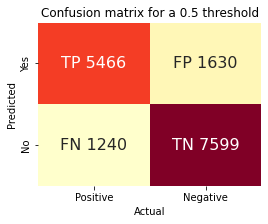

In [90]:
# Plot confusion matrix
confusion_matrix_05 = compute_confusion_matrix(y_test, y_pred, decision_threshold=0.5)
plt.figure(figsize = (4,3)) 
ax = plot_confusion_matrix(confusion_matrix_05)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix for a 0.5 threshold')

In [91]:
# Print all scores
[accuracy, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative] = compute_all_score(confusion_matrix_05)

print(f"The accuracy of this model is {accuracy:1.3f}")
print(f"For the positive case, the precision is {precision_positive:1.3f}, the recall is {recall_positive:1.3f} and the F1 score is {F1_score_positive:1.3f}")
print(f"For the negative case, the precision is {precision_negative:1.3f}, the recall is {recall_negative:1.3f} and the F1 score is {F1_score_negative:1.3f}")

The accuracy of this model is 0.820
For the positive case, the precision is 0.770, the recall is 0.815 and the F1 score is 0.792
For the negative case, the precision is 0.860, the recall is 0.823 and the F1 score is 0.841


### C) Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold.

In [93]:
# create threshold array from 0 to 1 (100 vals in b/w, e.g, 0.01, 0.02,...0.99)
thresholds = np.linspace(0, 1, 100)

# store scores i-e [t, accuracy, precision_positive,....] for each threshold --> it will act as a row for our new df (next cell)
list_of_scores = []

for threshold in thresholds:
    confusion_matrix = compute_confusion_matrix(y_test, y_pred, decision_threshold=threshold)
    scores = compute_all_score(confusion_matrix)
    list_of_scores.append(scores)

In [96]:
# create df using list_of_scores
col_names = ['Accuracy', 'Precision P', 'Recall P', 'F1 score P', 'Precision N', 'Recall N', 'F1 score N']
threshold_df = pd.DataFrame(list_of_scores , columns=col_names)

# add threshold col
threshold_df['Threshold'] = thresholds

threshold_df


,Accuracy,Precision P,Recall P,F1 score P,Precision N,Recall N,F1 score N,Threshold
0,0.420835,0.420835,1.000000,0.592377,NaN,0.000000,NaN,0.000000
1,0.496078,0.455064,0.999702,0.625431,0.998337,0.130133,0.230253,0.010101
2,0.524443,0.469455,0.999254,0.638799,0.996990,0.179434,0.304132,0.020202
3,0.538751,0.477049,0.998061,0.645544,0.993176,0.205006,0.339860,0.030303
4,0.557703,0.487524,0.996421,0.654713,0.989233,0.238921,0.384884,0.040404
...,...,...,...,...,...,...,...,...
95,0.592720,0.857616,0.038622,0.073916,0.587603,0.995341,0.738959,0.959596
96,0.589583,0.860870,0.029526,0.057093,0.585610,0.996533,0.737708,0.969697
97,0.586947,0.856322,0.022219,0.043314,0.583973,0.997291,0.736615,0.979798
98,0.583433,0.809091,0.013272,0.026115,0.581864,0.997725,0.735052,0.989899


Text(0.5, 1.0, 'Accuracy')

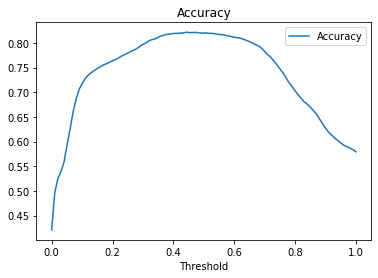

In [ ]:
# plot accuracy
threshold_df.plot(x='Threshold', y='Accuracy').set_title('Accuracy')

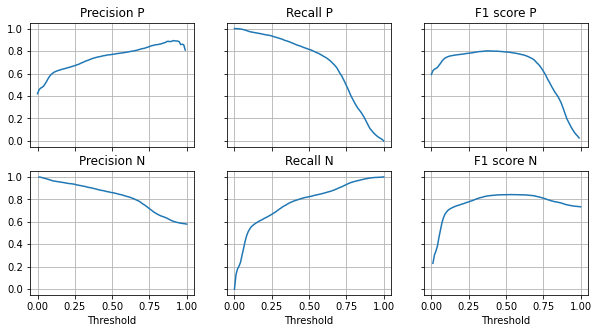

In [105]:
# plot other scores (6 in total = 3x2 subplots)
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10,5)) # sharex --> all subplots share same x-axis

col_names = ['Precision P', 'Recall P', 'F1 score P', 'Precision N', 'Recall N', 'F1 score N']

for ax, col in zip(axs.flat, col_names):
    threshold_df.plot(x='Threshold', y=col, ax=ax, grid=True, legend=False)
    ax.set_title(col)

### D) Plot in a bar chart the coefficients of the logistic regression sorted by their contribution to the prediction.

In [107]:
logistic = LogisticRegression(solver='lbfgs', max_iter=10000)
logistic.fit(X_train_stdz, y_train)


LogisticRegression(max_iter=10000)

In [112]:
# create a df containing feature & its coefficient as found by logistic regression model
rows = []
for col, coeff in zip(X_test_stdz.columns, logistic.coef_[0]):
    row_data = {'feature': col, 'coeff': coeff}
    rows.append(row_data)
    
features_coef = pd.DataFrame(rows)
features_coef

,feature,coeff
0,age_upon_outcome_(years),1.348632
1,age_upon_intake_(years),-1.734257
2,intake_year,0.204367
3,intake_number,0.055693
4,time_in_shelter_days,0.789315
5,sex_upon_outcome_Intact Female,-0.689272
6,sex_upon_outcome_Intact Male,-0.781497
7,sex_upon_outcome_Neutered Male,0.643251
8,sex_upon_outcome_Spayed Female,0.653575
9,sex_upon_outcome_Unknown,-0.487283


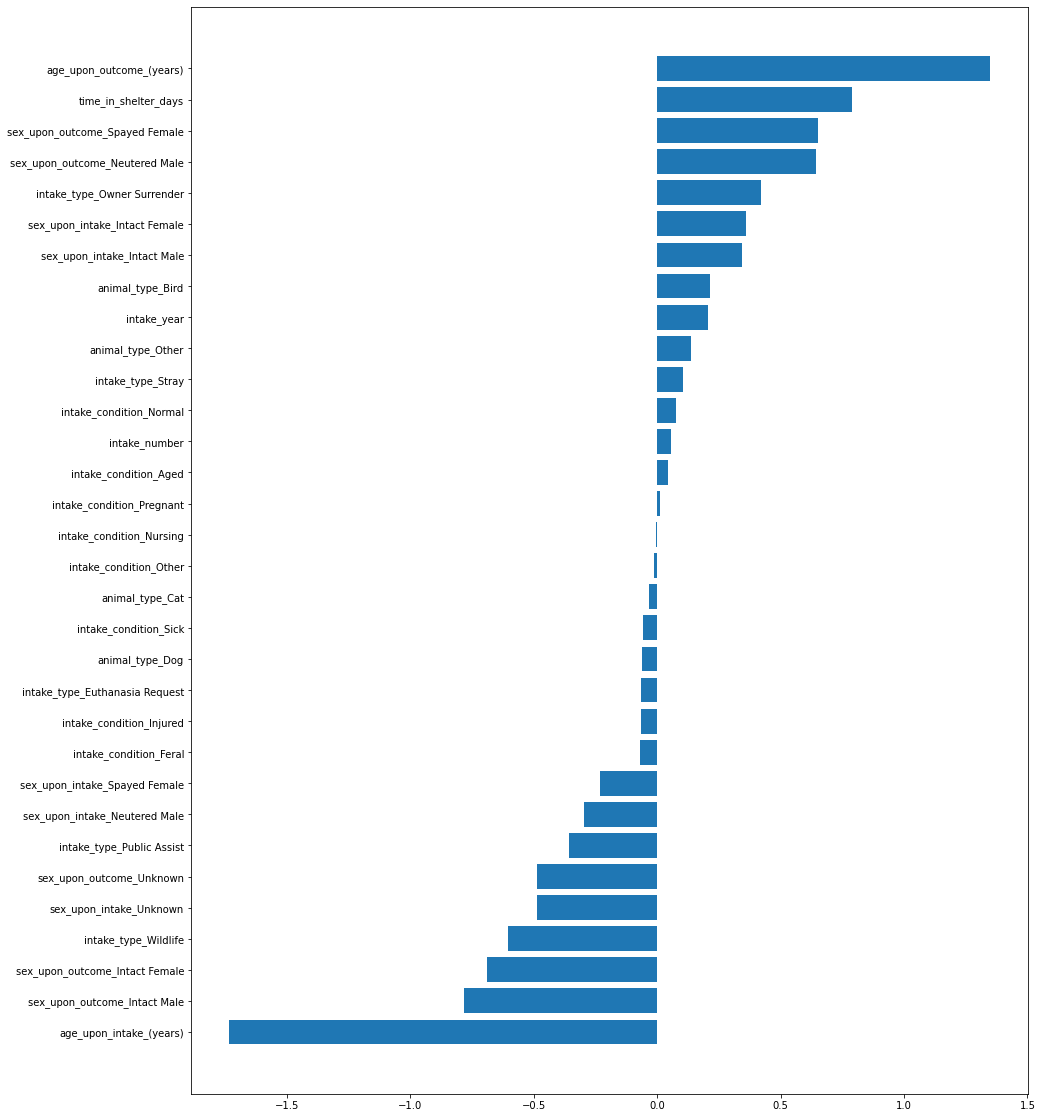

In [126]:
# plot barchart to show coeff val for each feature
features_coef.sort_values(by='coeff', inplace=True) # sort in ascending order (helps in visualizing)
plt.figure(figsize=(15,20))
plt.barh(features_coef['feature'], features_coef['coeff']);


## Question 1: Which of the following metrics is most suitable when you are dealing with unbalanced classes?

- a) F1 Score
- b) Recall
- c) Precision
- d) Accuracy

In [ ]:
'''
Answer: (a) F1 Score

- F1 Score is the most suitable metric because it considers both Precision & Recall and provides a balanced measure.

Unbalanced Class (or Imbalanced Dataset):
    - when the distribution of classes is not equal. One class has significantly more samples than the other class(es).
    - E.g, Suppose you're building a model to detect fraud. In your overall dataset: 
        - 99% of transactions are legitimate (majority class), but only 1% of are fraud (minority class).
    - Model tends to predict majority class more often, ignoring the minority class.

- Accuracy?
    - Accuracy can be misleading with unbalanced data. E.g, in overall dataset with 99% of one class and 1% of another, a model that always predicts majority class would have 99% accuracy but fail to detect minority class.

- Recall & Precision?
    - Recall focuses only on out of total actual positives how many were correctly identified, ignoring false positives
    - Precision just focuses on how many of the predicted positives are correct, ignoring how many positives in total were missed

'''

## Question 2: You are working on a binary classification problem. You trained a model on a training dataset and got the following confusion matrix on the test dataset. What is true about the evaluation metrics (rounded to the second decimal point):

|            | Pred = NO|Pred=YES|
|------------|----------|--------|
| Actual NO  |    50    |   10   |
| Actual YES |    5     |   100  |

- a) Accuracy is 0.95
- b) Accuracy is 0.85
- c) False positive rate is 0.95
- d) True positive rate is 0.95

In [ ]:
'''
Correct: (d) True positive rate is 0.95

--------------------------------

Accuracy = TP/(TP+FP) = 100/(100+10) = 100/110 = 0.90

FPR = FP/(FP+TN) = 10/(10+50) = 10/60 = 0.167

TPR = Recall = TP/(TP+FN) = 100/(100+5) = 0.95


'''